In [3]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [4]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

2024-06-23 15:08:53.454962: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-23 15:08:53.697109: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 15:08:54.444736: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
df = pd.read_csv('/home/thu/LaptrinhAI/Final_term/hanoi-aqi-weather-data.csv',
                 parse_dates=['Local Time', 'UTC Time'],
                 index_col=['Local Time'])
df.head()

,UTC Time,City,Country Code,Timezone,AQI,CO,NO2,O3,PM10,PM25,SO2,Clouds,Precipitation,Pressure,Relative Humidity,Temperature,UV Index,Wind Speed
Local Time,,,,,,,,,,,,,,,,,,
2023-06-08 00:00:00,2023-06-07 17:00:00,Hanoi,VN,Asia/Ho_Chi_Minh,118,168.7,32.3,74.7,52.5,42.0,57.3,37,0.5,1004,87,29.3,0.0,1.33
2023-06-08 01:00:00,2023-06-07 18:00:00,Hanoi,VN,Asia/Ho_Chi_Minh,115,169.8,32.0,66.0,51.3,41.0,64.0,50,1.0,1004,88,29.0,0.0,1.00
2023-06-08 02:00:00,2023-06-07 19:00:00,Hanoi,VN,Asia/Ho_Chi_Minh,112,166.7,29.3,63.7,50.0,40.0,66.0,62,1.0,1003,89,28.9,0.0,0.66
2023-06-08 03:00:00,2023-06-07 20:00:00,Hanoi,VN,Asia/Ho_Chi_Minh,121,163.6,26.7,61.3,53.8,43.0,68.0,75,0.5,1003,90,28.7,0.0,0.33
2023-06-08 04:00:00,2023-06-07 21:00:00,Hanoi,VN,Asia/Ho_Chi_Minh,134,160.5,24.0,59.0,60.0,48.0,70.0,87,0.0,1003,92,28.6,0.0,1.20


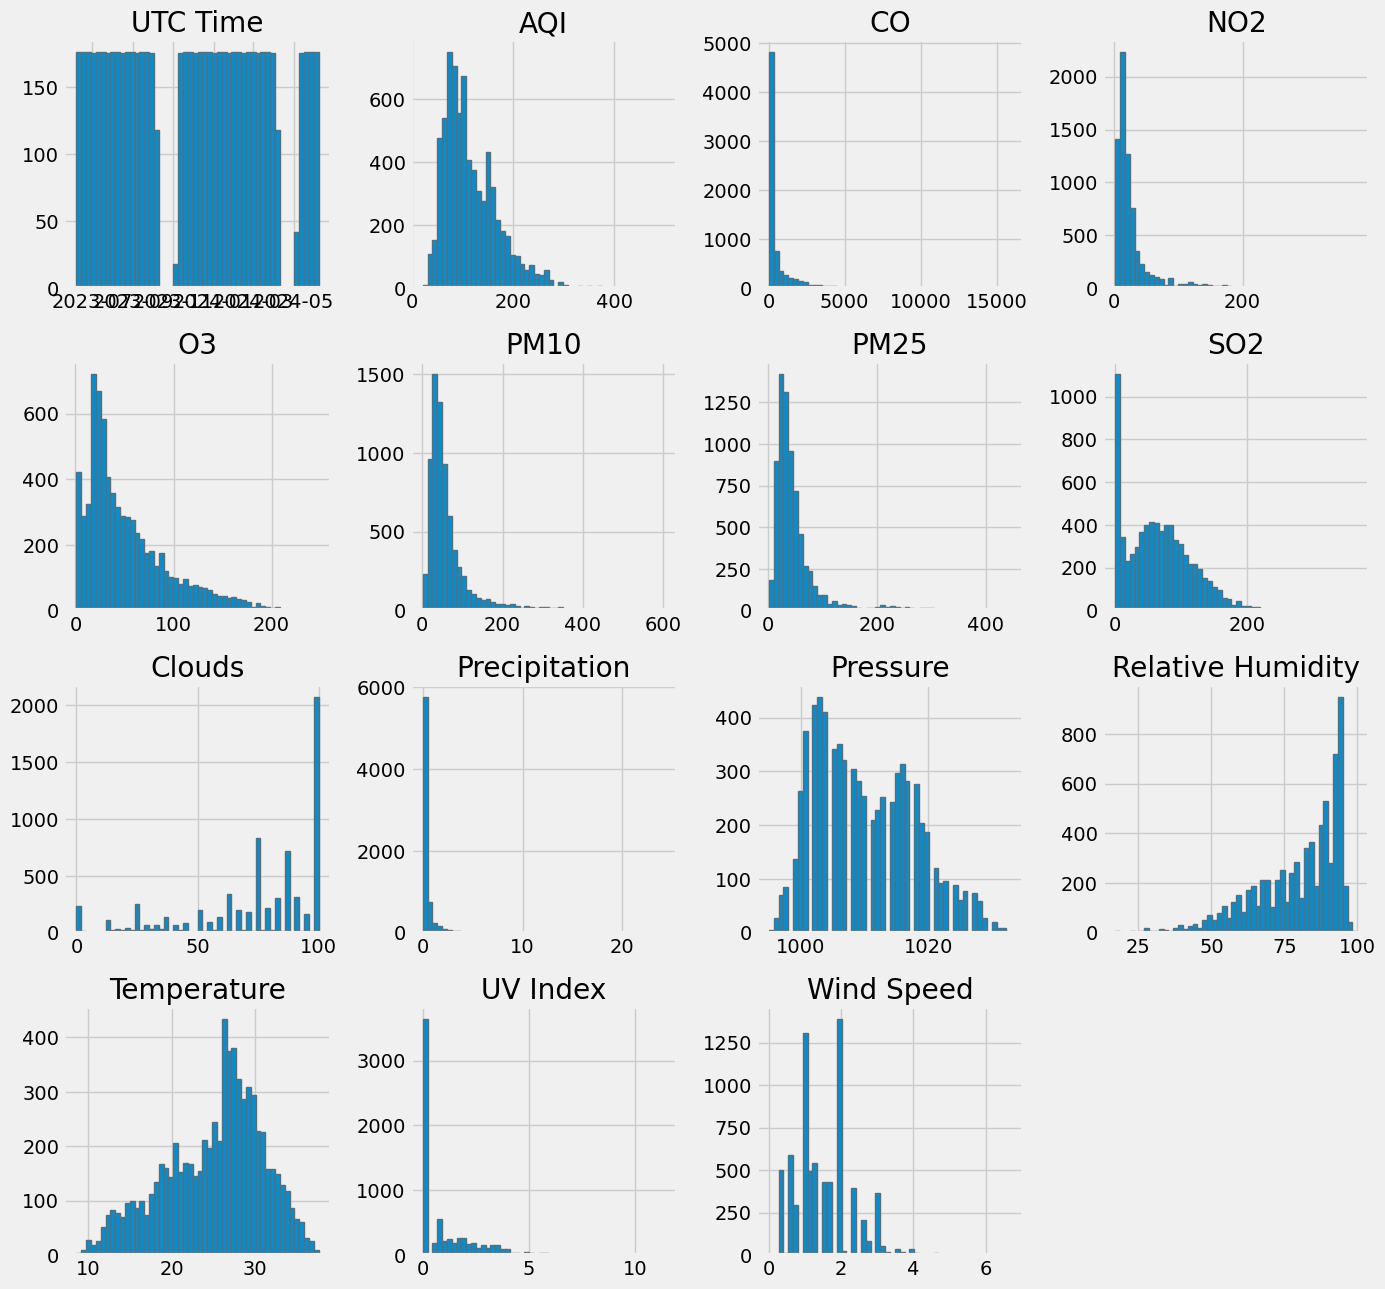

In [6]:
df.hist(bins=50, figsize=(15,15));

In [7]:
dataset_columns = df.columns.tolist()
dataset_columns

['UTC Time',
 'City',
 'Country Code',
 'Timezone',
 'AQI',
 'CO',
 'NO2',
 'O3',
 'PM10',
 'PM25',
 'SO2',
 'Clouds',
 'Precipitation',
 'Pressure',
 'Relative Humidity',
 'Temperature',
 'UV Index',
 'Wind Speed']

<Axes: >

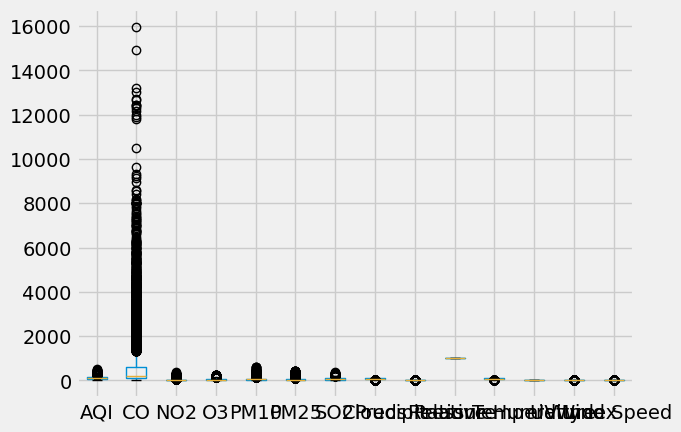

In [8]:
df.boxplot()

## Xác định biến mục tiêu

<Axes: >

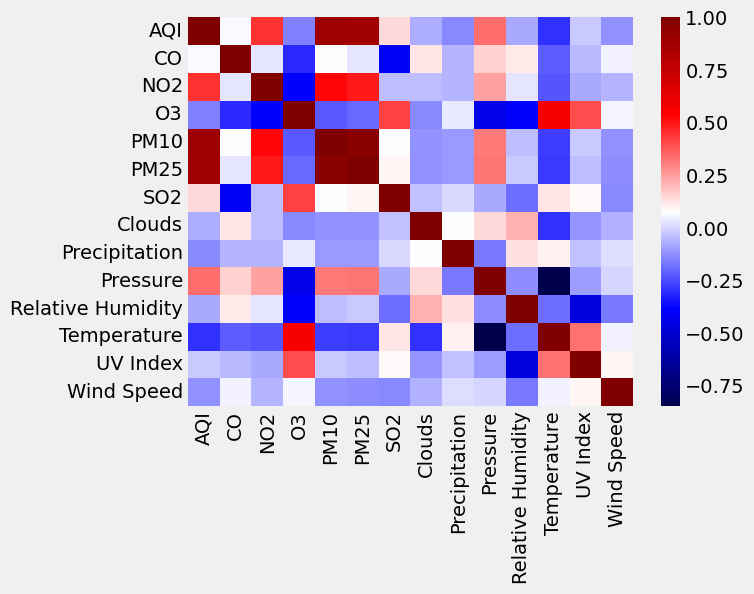

In [9]:
df_num = df[['AQI', 'CO', 'NO2',
       'O3', 'PM10', 'PM25', 'SO2', 'Clouds', 'Precipitation', 'Pressure',
       'Relative Humidity', 'Temperature', 'UV Index', 'Wind Speed']]
data = df_num.copy(deep=True)
sns.heatmap(data.corr(), cmap='seismic')

In [10]:
data.drop(columns=['CO', 'Clouds', 'UV Index', 'SO2', 'Precipitation'], inplace=True)

In [11]:
data.head()

,AQI,NO2,O3,PM10,PM25,Pressure,Relative Humidity,Temperature,Wind Speed
Local Time,,,,,,,,,
2023-06-08 00:00:00,118,32.3,74.7,52.5,42.0,1004,87,29.3,1.33
2023-06-08 01:00:00,115,32.0,66.0,51.3,41.0,1004,88,29.0,1.00
2023-06-08 02:00:00,112,29.3,63.7,50.0,40.0,1003,89,28.9,0.66
2023-06-08 03:00:00,121,26.7,61.3,53.8,43.0,1003,90,28.7,0.33
2023-06-08 04:00:00,134,24.0,59.0,60.0,48.0,1003,92,28.6,1.20


In [85]:
from sklearn.preprocessing import MinMaxScaler

values = data[['AQI', 'PM25']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(values)
     

In [86]:
#Creating a window for previous data
def to_supervised(train):
  window_size = 1
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
    
  return X,Y
     

In [87]:
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)


Y (7322, 1)
X (7322, 1, 2)


In [88]:
train_size = int(len(dataset) * 0.25)
X_train, X_test = X[train_size:,] , X[:train_size,]
print('X_train' ,X_train.shape)
print('X_test' ,X_test.shape)

Y_train, Y_test = Y[train_size:,] , Y[:train_size,]
print('Y_train' ,Y_train.shape)
print('Y_test' ,Y_test.shape)

X_train (5492, 1, 2)
X_test (1830, 1, 2)
Y_train (5492, 1)
Y_test (1830, 1)


In [89]:
#Importing LSTM model
from keras.models import Sequential
from keras.layers import Dense, Dropout,LSTM
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')         
     

In [90]:
#Train the model
model.fit(X_train, Y_train, epochs = 100, batch_size = 32)

Epoch 1/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0264
Epoch 2/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0053
Epoch 3/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0055
Epoch 4/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047
Epoch 5/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0049
Epoch 6/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0046
Epoch 7/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044
Epoch 8/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0051
Epoch 9/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0044
Epoch 10/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048
Epoch 11/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0048
Epoch 12/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0043
Epoch 13/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047
Epoch 14/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0047
Epoch 15/100
172/172 ━━━━━━━━━━━━━━━━━━━━ 0

In [77]:
#Taking predictions
from keras.models import load_model
model.save('AirPollutionMultivariate.h5')

ImportError: cannot import name 'load_model' from 'keras.models' (/home/thu/miniconda3/envs/programmingAI/lib/python3.9/site-packages/keras/models/__init__.py)

In [142]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

#Scaling back to the original scale
dtrain = scaled_dataset[:5492, :]
Ytrain_predicted = np.concatenate((trainPredict,d[:5492,1:]), axis =1)
print('concat ytrain_pre', trainPredict.shape)
Ytrain_predicted = scaler.inverse_transform(Ytrain_predicted)
Ytrain_predicted = Ytrain_predicted[:,0:1]
print('Ytrain_predicted', Ytrain_predicted.shape)

dtest = scaled_dataset[:1830,:]
print('dummy',d.shape)
print('testPredict',testPredict.shape)
Ytest_predicted = np.concatenate((testPredict,d[:1830,1:]), axis =1)
print('concat ytest_pred',testPredict.shape)
Y_tested = np.concatenate((Y_test, d[:1830,1:]), axis = 1)
print('concat Y_test', Y_test.shape)
Ytest_predicted = scaler.inverse_transform(Ytest_predicted)
Y_tested = scaler.inverse_transform(Y_tested)
Ytest_predicted = Ytest_predicted[:,0:1]
Y_tested = Y_tested[:,0:1]
print('Y_tested', Y_tested.shape)
print('Ytest_predicted', Ytest_predicted.shape)
     

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
concat ytrain_pre (5492, 1)
Ytrain_predicted (5492, 1)
dummy (5492, 2)
testPredict (1830, 1)
concat ytest_pred (1830, 1)
concat Y_test (1830, 1)
Y_tested (1830, 1)
Ytest_predicted (1830, 1)


In [113]:

print('y_predicted',testPredict.shape)
#print('X_train' ,X_train.shape)
print('X_test' ,X_test.shape)
print('scaled Values shape', scaled_dataset.shape)
     

y_predicted (1830, 1)
X_test (1830, 1, 2)
scaled Values shape (7323, 2)


In [120]:
Y_predicted

array([[130.20291382],
       [127.22162902],
       [124.22033738],
       ...,
       [ 79.71475614],
       [113.70931064],
       [ 94.65530169]])

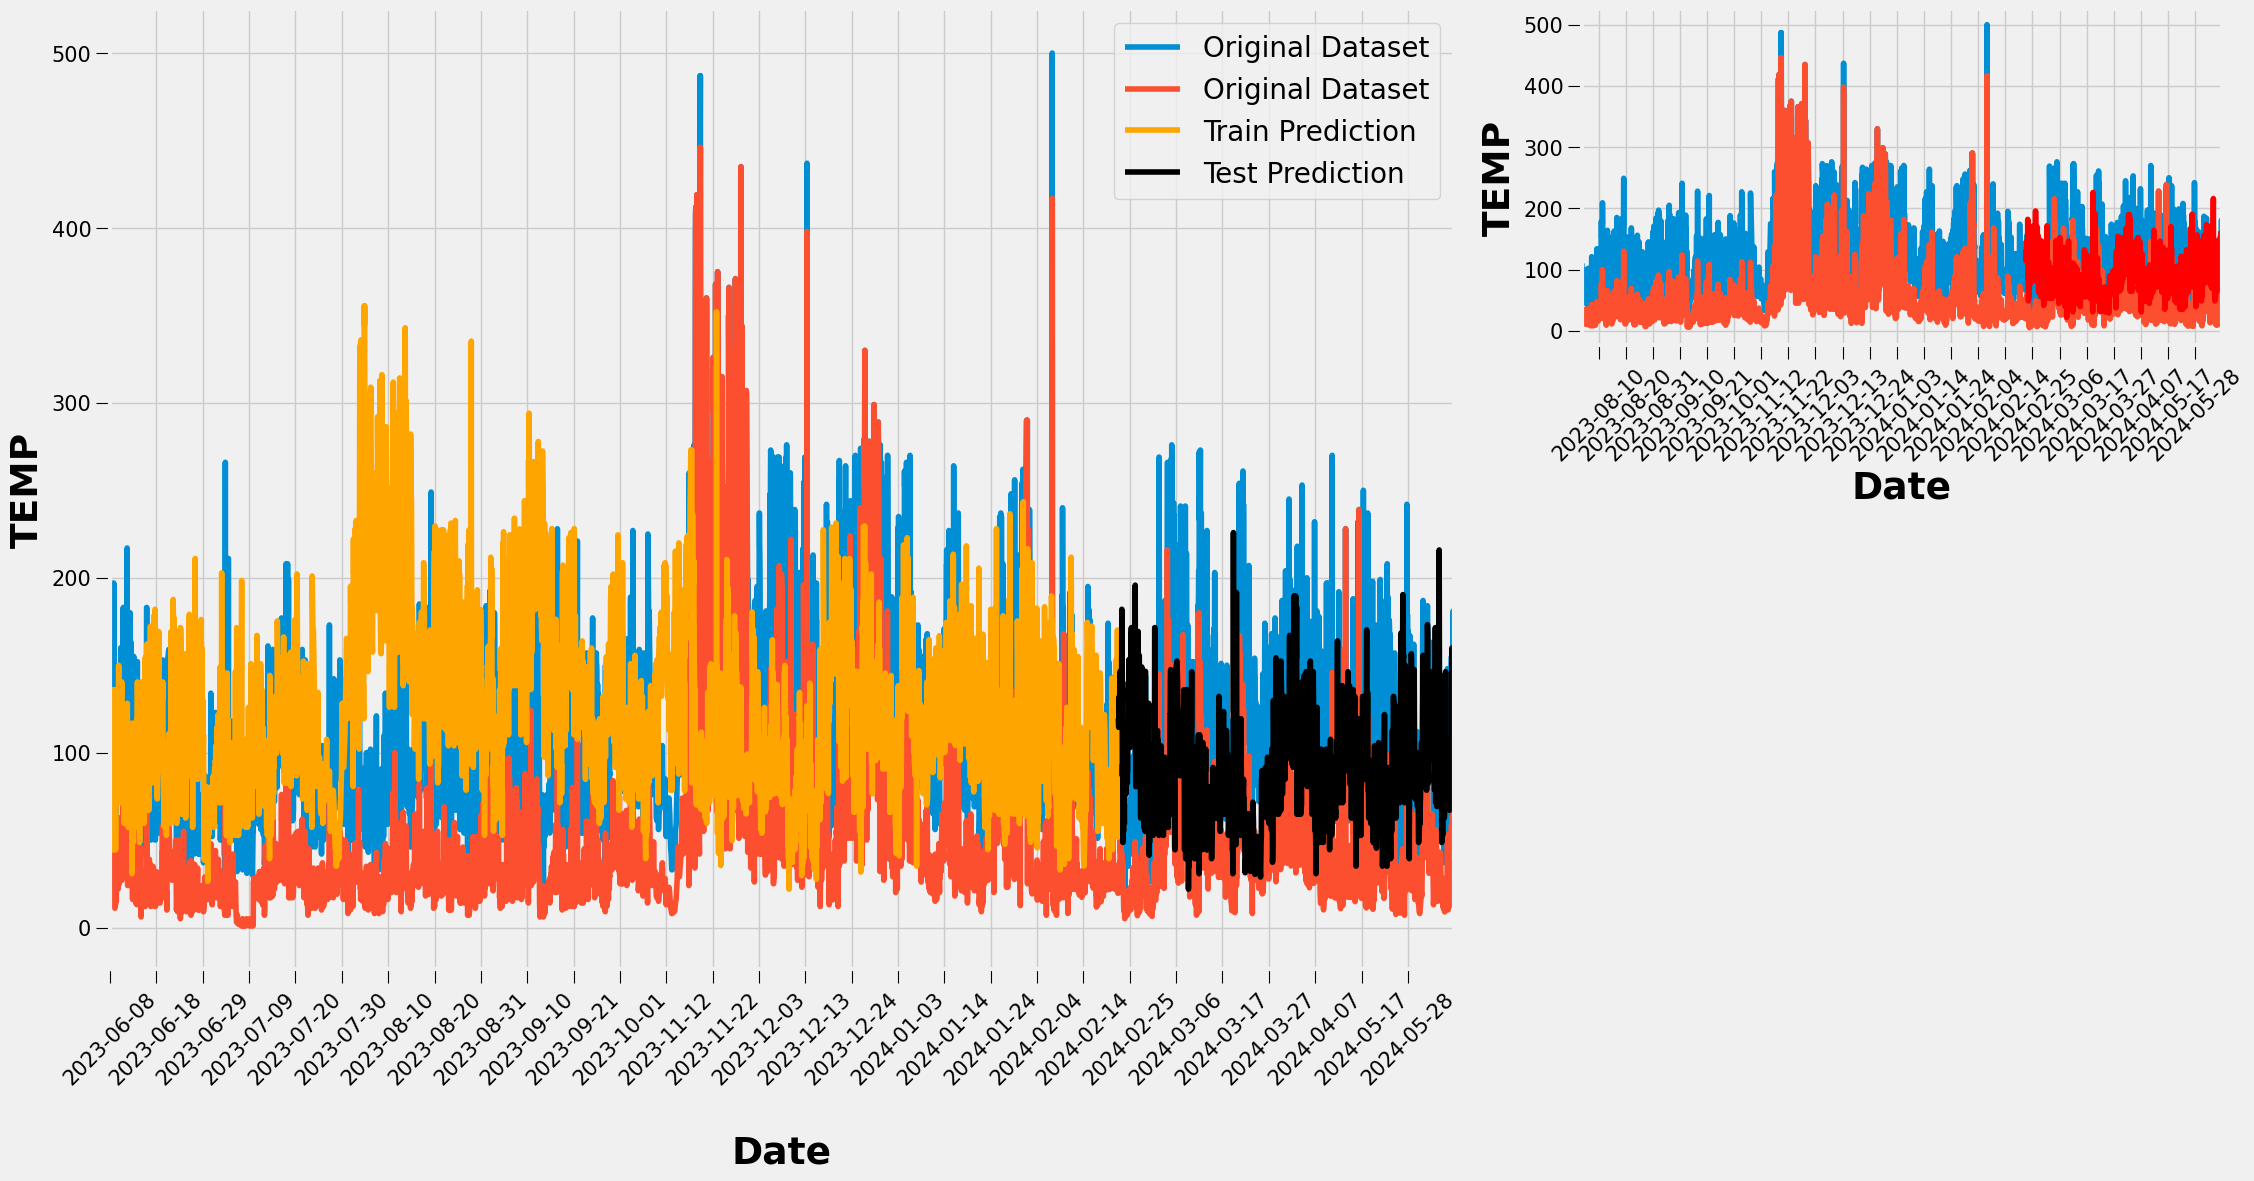

In [144]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(Y)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(Ytrain_predicted)+look_back, :] = Ytrain_predicted

# shift test predictions for plotting
testPredictPlot = np.empty_like(Y)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(Ytrain_predicted):len(Y), :] = Ytest_predicted

# plot original dataset and predictions
time_axis = np.linspace(0, dataset.shape[0]-1, 30)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(data.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])

ax.plot(scaler.inverse_transform(scaled_dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='black', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('TEMP', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,7321])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(scaler.inverse_transform(scaled_dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('TEMP', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,7321]);